#### CSC 180  Intelligent Systems (Spring 2021)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento

## Lab 12： Distributed Evolutionary Algorithms in Python (DEAP) Basics

## Elements to take into account using evolutionary algorithms

* **Individual representation** (binary, Gray, floating-point, etc.);
* **evaluation** and **fitness assignment**;
* **mating selection**, that establishes a partial order of individuals in the population using their fitness function value as reference and determines the degree at which individuals in the population will take part in the generation of new (offspring) individuals.
* **variation**, that applies a range of evolution-inspired operators, like crossover, mutation, etc., to synthesize offspring individuals from the current (parent) population. This process is supposed to prime the fittest individuals so they play a bigger role in the generation of the offspring.
* **environmental selection**, that merges the parent and offspring individuals to produce the population that will be used in the next iteration. This process often involves the deletion of some individuals using a given criterion in order to keep the amount of individuals bellow a certain threshold.
* **stopping criterion**, that determines when the algorithm shoulod be stopped, either because the optimum was reach or because the optimization process is not progressing.

# Hence a 'general' evolutionary algorithm can be described as

```python
def evolutionary_algorithm():
    'Pseudocode of an evolutionary algorithm'    
    populations = [] # a list with all the populations
    
    populations[0] =  initialize_population(pop_size)
    t = 0
    
    while not stop_criterion(populations[t]):
        fitnesses = evaluate(populations[t])
        offspring = matting_and_variation(populations[t],
                                          fitnesses)
        populations[t+1] = environmental_selection(           
                                          populations[t],
                                          offspring)
        t = t+1
```


# Python libraries for evolutionary computation

* PaGMO/PyGMO
* Inspyred
* **Distributed Evolutionary Algorithms in Python (DEAP)**


<table>
<tr>
<td width='47%'>
<img src='https://raw.githubusercontent.com/DEAP/deap/master/doc/_static/deap_long.png' title="DEAP logo" width='92%' align='center'/>
</td>
<td>
<ul>
<li> Open source Python library with,
<li> genetic algorithm using any representation;
<li> evolutionary strategies (including CMA-ES);
<li> multi-objective optimization from the start;
<li> co-evolution (cooperative and competitive) of multiple populations;
<li> parallelization of the evaluations (and more) using SCOOP;
<li> statistics keeping, and;
<li> benchmarks module containing some common test functions.
<li> [https://github.com/DEAP/deap](https://github.com/DEAP/deap)
</ul>
</td>
</tr>
</table>


### To install:  pip install deap

## Let's take the One Max problem as an example 



### Maximize the number of ones in a binary string (list, vector, etc.).
* More formally, from the set of binary strings of length $n$,
$$\mathcal{S}=\left\{s_1,\ldots,s_n\right\}, \text{ with } s_i=\left\{0,1\right\}.$$
* Find $s^\ast\in\mathcal{S}$ such that
$$s^\ast = \operatorname*{arg\,max}_{s\in\mathcal{S}} \sum_{i=1}^{n}{s_i}.$$
### Its clear that the optimum is an *all-ones* string.

# Coding the problem


## Imports
We first get the required modules for our evolution.

- `random` gives us a way to generate random bits;
- `base` gives us access to the Toolbox and base Fitness;
- `creator` allows us to create our types;
- `tools` grants us access to the operators bank;
- `algorithms` enables us some ready generic evolutionary loops.

In [1]:
import random
import numpy as np
import pandas as pd
from deap import base, creator, tools, algorithms

## Step 1:  Create the Fitness class and the Individual class using create()


First step with DEAP is to create the required types. Usually the types created are the fitness and the individual. 


### Fitness Class

For the OneMax problem, we want to have a solution with as many ones as possible. Thus we need a maximizing fitness.


***The create() function takes at least two arguments, a name for the newly created class and a base class***. ***Any subsequent argument becomes an attribute of the class***. 


In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

The weights attribute must be a ***tuple*** so that multi-objective and single objective fitnesses can be treated the same way. A FitnessMulti would be created the same way but using:

`creator.create("FitnessMulti", base.Fitness, weights=(-1.0, 1.0))`


This code produces a fitness that minimizes the first objective and maximize the second one. The weights can also be used to vary the importance of each objective one against another. This means that the weights can be any real number and only the sign is used to determine if a maximization or minimization is done. 


### Individual Class

For the OneMax problem, we want to have a solution with as many ones as possible. Thus we need a maximizing fitness and a individual that is a `list`.

Next we create an Individual class, using the creator, that will inherit from the standard list type and have a fitness attribute.


In [3]:
creator.create("Individual", list, fitness=creator.FitnessMax)

The created classes are made available in the creator module. We can instantiate directly objects of the created class like follow. This step is not required in an algorithm, the instatiation will be automated later.

***You may use the following code to test if you create the individual class successfully***

In [4]:
ind = creator.Individual([1, 0, 1, 1, 0])

print(ind)
print(type(ind))
print(type(ind.fitness))

[1, 0, 1, 1, 0]
<class 'deap.creator.Individual'>
<class 'deap.creator.FitnessMax'>


## Step 2: Based on the individual representation, define your functions so DEAP can know how to instantiate each individual and the first population

* ***Functions are defined/registered using register() method, which takes at least two arguments; an alias and a function assigned to this alias. Any subsequent argument is passed to the function when called.***



###  If each individual is  a list of boolean values:

In [5]:
toolbox = base.Toolbox()

toolbox.register("attr_bool", random.randint, 0, 1)
# random.randint(0, 1)  yields 0 or 1

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

This first one, `attr_bool`, calls randint from the random module with arguments (0, 1) to create an integer in the interval $[0, 1]$. 

The second function, `individual` will use the `initRepeat` function made available in the tools module to fill an `Individual` class with what is produced by 10 calls to the previously defined `attr_bool` function. 

The same thing is done for the population function.


***You may use the following code to test:***

For example, calling every function individually shows how it proceeds.

In [6]:
bit = toolbox.attr_bool()
print((type(bit), bit))


(<class 'int'>, 1)


In [7]:
ind = toolbox.individual()
print((type(ind), len(ind), ind))


(<class 'deap.creator.Individual'>, 10, [0, 1, 1, 1, 0, 0, 0, 1, 0, 1])


In [8]:
pop = toolbox.population(n=3)
print((type(pop), len(pop), pop))

(<class 'list'>, 3, [[1, 1, 1, 0, 0, 1, 0, 0, 0, 0], [0, 1, 0, 0, 1, 1, 0, 1, 0, 1], [0, 0, 1, 1, 1, 0, 1, 1, 0, 0]])


###   If each individual is a list of float values: 

In [9]:
toolbox1 = base.Toolbox()
toolbox1.register("attr_float", random.random)
toolbox1.register("individual", tools.initRepeat, creator.Individual,
                 toolbox1.attr_float, n=10)
toolbox1.register("population", tools.initRepeat, list, toolbox1.individual)


***You may use the following code to test:***

In [10]:
ind1 = toolbox1.individual()
print((type(ind1), len(ind1), ind1))

(<class 'deap.creator.Individual'>, 10, [0.900396935800829, 0.7623427338161614, 0.9083902171118362, 0.44789021480535196, 0.252687923077377, 0.29657620455068034, 0.15565398617403714, 0.1999084230121434, 0.4262621409584534, 0.22554403055497252])


In [11]:
pop1 = toolbox1.population(n=3)
print((type(pop1), len(pop1), pop1))

(<class 'list'>, 3, [[0.9949817409342597, 0.9904643371001424, 0.7346872929178914, 0.9497342366934327, 0.29577602046530105, 0.9452499899572204, 0.43446669865284615, 0.22515873490663962, 0.11572275804896592, 0.3875859260555712], [0.46901449509417126, 0.4635328024169798, 0.9219312983584125, 0.4368108240762312, 0.4425056010864077, 0.20513245371504363, 0.42341204335245064, 0.36763553717524144, 0.9251649564856627, 0.3803293679043639], [0.7083745673123716, 0.5049672949707423, 0.12402799009069165, 0.4898319391258199, 0.8098458072270533, 0.8886862848568075, 0.6726771235862263, 0.2717703349790085, 0.5943951605192732, 0.7278761106930277]])


###  If each individual is a list of integer values:

In [12]:
toolbox2 = base.Toolbox()
toolbox2.register("attr_int", random.randint, 0, 10)
toolbox2.register("individual", tools.initRepeat, creator.Individual,
                 toolbox2.attr_int, n=10)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)

***You may use the following code to test:***

In [13]:
ind2 = toolbox2.individual()
print(ind2)

[7, 7, 4, 2, 2, 4, 9, 5, 2, 6]


In [14]:
pop2 = toolbox2.population(n=3)
print((type(pop2), len(pop2), pop2))

(<class 'list'>, 3, [[2, 6, 3, 7, 3, 9, 10, 7, 10, 6], [1, 7, 5, 8, 4, 8, 10, 1, 8, 10], [1, 8, 5, 5, 1, 8, 7, 8, 10, 2]])


###  If each individual is a permutation:

An individual for the permutation representation is almost similar to the general list individual. In fact they both inherit from the basic list type. The only difference is that instead of filling the list with a series of floats, we need to generate a random permutation and provide that permutation to the individual.

In [15]:
toolbox3 = base.Toolbox()

toolbox3.register("indices", np.random.permutation, 10)
# np.random.permutation (10) return array([0, 6, 4, 8, 5, 2, 9, 1, 3, 7])

toolbox3.register("individual", tools.initIterate, creator.Individual,
                 toolbox3.indices)
toolbox3.register("population", tools.initRepeat, list, toolbox3.individual)


***You may use the following code to test:***

In [16]:
ind1 = toolbox3.individual()
print(ind1)

[8, 5, 7, 3, 9, 0, 6, 4, 2, 1]


In [17]:
pop3 = toolbox3.population(n=3)
print((type(pop3), len(pop3), pop3))

(<class 'list'>, 3, [[0, 5, 6, 1, 3, 8, 7, 9, 2, 4], [5, 9, 7, 8, 6, 0, 4, 3, 1, 2], [8, 1, 7, 5, 3, 0, 6, 9, 4, 2]])


## Step 3:  Define fitness evaluation function fo each individual 

The evaluation function is pretty simple for the OneMax problem, we need to count the number of ones in an individual. 

### Notice that ***the returned value must be an tuple, equal to the number of objectives.***

***Notice the comma following sum()!!***

In [18]:
def evalOneMax(individual):
    return (sum(individual),)      # return type should be tuple


# E.g., sum([1, 0, 1, 0, 1, 1, 0, 1, 1, 0]) returns 6

## Step 4: Define genetic operators

* The usual names for the operators are mate(), mutate(), evaluate() and select(). Registering the operators and their default arguments in the toolbox is done as follow.

`All possible operaters`:  https://deap.readthedocs.io/en/master/api/tools.html

In [19]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)

The evaluation is given the alias `evaluate`.  `evalOneMax` will be called with the signature `toolbox.evaluate(individual)`   that takes the individual as input, which will be given later.

The two points crossover function is registered the same way under the alias `mate`. 

The mutation set the `independent probability of each attribute to be mutated` (`indpb`) to 0.1.   In the algorithms, the mutate() function is called with the signature `toolbox.mutate(individual)`

Finally, the selection operator is `K-way turnament selection`, registered under the name `select` and the size of the tournament set to 3.

***We can for example mutate an individual and expect 10% of its attributes to be flipped.***

***You may use the following code to test:***

In [20]:
ind = toolbox.individual()
print(ind)

toolbox.mutate(ind)
print(ind)

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0]
[1, 0, 1, 1, 0, 1, 0, 1, 1, 0]


## Step 5:  Choose your algorithm and let evolution go!
https://deap.readthedocs.io/en/master/api/algo.html

* There are several algorithms implemented in the algorithms module.  
* In order to setup a toolbox for an algorithm, you must register the desired operators under a specified names.

#### The *simple evolutionary algorithm* takes 5 arguments, a population, a toolbox, a probability of cross-overing two individuals (`cxpb`), a probability of mutating each individual (`mutpb`) and a number of generations to accomplish (`ngen`). 

Once the evolution is finished the population contains the individuals from the last generation.

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline  

pop = toolbox.population(n=100)

pop, log= algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10)

# nevals： the number of evalutions for each generation


gen	nevals
0  	100   
1  	55    
2  	59    
3  	55    
4  	58    
5  	52    
6  	46    
7  	47    
8  	61    
9  	51    
10 	59    


In [22]:
# Print out the last generation

pop

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
 [1, 1, 1,

In [23]:
best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)

Best individual is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [24]:
print('With fitness: ', toolbox.evaluate(best_ind))

With fitness:  (10,)


### Note: Computing Statistics and Hall of Fame

Here we will employ some helpful tools such as Statistics and a Hall of Fame. 

* The `statistics` are computed using numpy functions on the population, and the `hall of fame` keeps track of the best individuals that ever appeared during the evolution.  


#### To do Statistics, one need to register the desired statistic functions inside the statistic object.

In [25]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)

The statistics object is created using a key as first argument. This key must be supplied a function that will later be applied to the data on which the statistics are computed. The previous code sample uses the fitness.values attribute of each element.

In [26]:
import numpy as np

stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

* The statistical functions are now registered. 
* The register function expects an alias as first argument and a function operating on vectors as second argument. 
* Any subsequent argument is passed to the function when called. The creation of the statistics object is now complete.

In [27]:
pop = toolbox.population(n=50)

hof = tools.HallOfFame(maxsize=1)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg 	min	max
0  	50    	4.82	1  	8  
1  	29    	5.96	3  	8  
2  	27    	6.78	4  	9  
3  	35    	7.4 	5  	9  
4  	36    	8.3 	6  	10 
5  	31    	8.76	7  	10 
6  	26    	9.14	7  	10 
7  	26    	9.48	7  	10 
8  	28    	9.68	6  	10 
9  	27    	9.78	7  	10 
10 	29    	9.84	8  	10 


* Statistics will automatically be computed on the population every generation. 
* The verbose argument prints the statistics on screen while the optimization takes place.
* Once the algorithm returns, the final population and a Logbook are returned. 

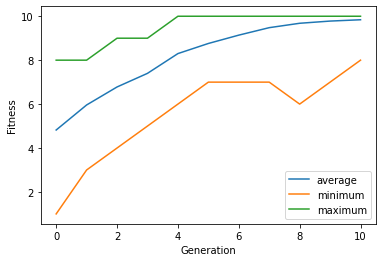

In [28]:
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")

plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [29]:
record = stats.compile(pop)
record

{'avg': 9.84, 'min': 8.0, 'max': 10.0}

#### Using Hall of Fame

Hall of Fame preserves the best individuals that appeared during an evolution. At every generation, it scans the population and saves the individuals in a separate archive that does not interact with the population. If the best solution disappears during the evolution, it will still be available in the hall of fame.

The hall of fame proposes a list interface where the individuals are sorted in descending order of fitness. Thus, the fittest solution can be retrieved by accessing the list's first element.

In [30]:
print("Best individual is: ", hof[0])

print("\nwith fitness: ", hof[0].fitness)

Best individual is:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

with fitness:  (10.0,)


### Super cool, right?

## Inside the black box:  Controlling everything instead of using the traditional black-box approach 

DEAP encourages users to rapidly build their own algorithms. With the different tools provided by DEAP, it is possible to design a nimble algorithm that tackles most problems at hand.

## Let's put everythong together and the "canned" eaSimple function can be replaced by lines 26-53.

In [31]:
import random
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evalOneMax(individual):
    return (sum(individual),)      # return type should be tuple



toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.10)
toolbox.register("select", tools.selTournament, tournsize=3)


pop = toolbox.population(n=10)


# begininng of the eaSimple function 

ngen, cxpb, mutpb = 40, 0.5, 0.2
fitnesses = toolbox.map(toolbox.evaluate, pop)

for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

for g in range(ngen):
    pop = toolbox.select(pop, k=len(pop))
    pop = [toolbox.clone(ind) for ind in pop]

    for child1, child2 in zip(pop[::2], pop[1::2]):
        if random.random() < cxpb:
            toolbox.mate(child1, child2)
            del child1.fitness.values, child2.fitness.values

    for mutant in pop:
        if random.random() < mutpb:
            toolbox.mutate(mutant)
            del mutant.fitness.values
        
    invalids = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalids)
    for ind, fit in zip(invalids, fitnesses):
        ind.fitness.values = fit
        
# end of the eaSimple function





best_ind = tools.selBest(pop, k=1)[0]

print('Best individual is:', best_ind)
print('With fitness: ', toolbox.evaluate(best_ind))


print()
print ("Last generation:")
for n in range(10):
    print (pop[n], pop[n].fitness.values)

Best individual is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
With fitness:  (10,)

Last generation:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] (10.0,)
/home/roemerq/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/roemerq/anaconda3/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that cla

First, the evaluation is applied to every individual in the population by the map function contained in every toolbox. Next, a loop over both the population and the evaluated fitnesses sets each individual's fitness value. 

Thereafter, the generational loop begins. It starts by selecting k individuals from the population, followed by the duplication of the population by the clone tool. Then, the crossover is applied to a portion of consecutive individuals . Each modified individual sees its fitness invalidated by the deletion of its value. Finally, a percentage of the population is mutated and their fitness values is also deleted. 

Only freshly produced individuals have to be evaluated; they are filtered by their fitness validity. 

This version of the program provides control over the application order and the number of operators, among many other aspects.